In [3]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
%matplotlib inline
import matplotlib
import requests
from pandas.io.json import json_normalize 
import time 
import csv
import os
from pprint import pprint

from ipyleaflet import Map, Heatmap, Marker, MarkerCluster
from random import uniform


In [4]:
#read in .csv file
hospital_data = pd.read_csv("CSV Folder/hospitals.csv")

#set index to state_name
hospital_data.set_index("state_name",inplace=True)

#group dataframe by state_name
hg = hospital_data.groupby('state_name')

#do count of hg dataframe (where it groups by states)to get total count of hospitals, doctors, staff,
#icu beds, and icu beds utilized. Then add each series to new dataframe called 'state_hospital_data'

hg["num_icu_be"].count()
state_hospital_data = pd.DataFrame(hg["num_icu_be"].count())

hospitals = hg["hospital_n"].count()
state_hospital_data["Number of Hospitals"]=hospitals

doctors = hg["num_licens"].count()
state_hospital_data["Number of Doctors"]=doctors

staff = hg["num_staffe"].count()
state_hospital_data["Number of Staff"]=staff

icu_beds = hg["num_icu_be"].count()
state_hospital_data["ICU Beds Available"]=icu_beds

bed_utiliz = hg["bed_utiliz"].count()
state_hospital_data["ICU Beds Utilized"]=bed_utiliz

#drop double num_icu_be column
state_hospital_data.drop("num_icu_be",axis=1, inplace = True)



In [5]:
# reaching out to API to get current overall state data pertaining to cases, tests, hospitalizations, and deaths
url3 = "https://covidtracking.com/api/states"
response3 = requests.get(url3)
#Turned entire response into a dataframe
US_df = json_normalize(response3.json(), errors='ignore')
#Narrowed df to specific columns of interest 
US_df = US_df.iloc[:,[0,1,8,9,22,16,10,19]]

#Read in a State Name Abbrev CSV so that df's could be joined with different state naming conventions
st_abrev = pd.read_csv("CSV Folder/Covid Analysis Data - StateNameAbrev.csv")

# Replacing the state abbreviation with names for joining to other data
tests_df = st_abrev.merge(US_df, how = 'inner',left_on = "Abbreviation",right_on = "state")

#Droping abbreviation column since no other dataset used abbrev.
tests_df.drop(columns = ["Abbreviation","state"],inplace = True)

#Joined hospital information with the general information
comb1_df= tests_df.merge(state_hospital_data,how = 'inner',left_on = "State",right_on = "state_name")
#comb1_df.drop(columns = "state_name", inplace = True)

#Read in file about rankings of aggressive measures limiting the virus spread
States_Most_Aggressive_Measures_df = pd.read_csv("CSV Folder/States with the Most Aggressive Measures in Limiting Virus Exposure.csv", encoding ='latin-1')

#Joined rankings data
comb2_df = comb1_df.merge(States_Most_Aggressive_Measures_df, how = 'inner', on = 'State' )

#Renamed Column Headers
comb2_df.rename(columns = {"positive":"Positive",
                           "negative":"Negative",
                           "pending":"Pending",
                           "totalTestResults": "Total Tested",
                           "recovered": "Recovered",
                           "hospitalizedCurrently":"Currently Hospitalized",
                           "death": "Total Deaths",
                           "num_icu_be":"ICU Beds",
                           "Prevention & Containment Rank": "Prevention & Containment Rank",
                           "Risk Factors & Infrastructure Rank": "Risk Factors & Infrastructure Rank",
                           "Economic Impact Rank": "Economic Impact Rank"}, inplace = True)

In [6]:
comb2_df.head()

,State,Positive,Negative,Pending,Total Tested,Recovered,Currently Hospitalized,Total Deaths,Number of Hospitals,Number of Doctors,Number of Staff,ICU Beds Available,ICU Beds Utilized,Overall Rank,Prevention & Containment Rank,Risk Factors & Infrastructure Rank,Economic Impact Rank,Delta in Overall Rank vs. March 23
0,Alabama,5231,43295,NaN,48526,NaN,NaN,177.0,120,120,120,66,109,48,48,45,2,-15
1,Alaska,329,10790,NaN,11119,168.0,42.0,9.0,28,28,28,7,23,3,2,11,40,11
2,Arizona,5251,49901,NaN,55152,1155.0,637.0,208.0,126,126,126,46,108,39,36,46,19,-1
3,Arkansas,2227,25214,NaN,27441,809.0,86.0,43.0,106,106,106,40,100,46,45,49,5,1
4,California,33261,266839,NaN,300100,NaN,4886.0,1268.0,466,466,466,302,401,18,15,44,16,-17


In [7]:
# Filter the DataFrame down only to those columns to chart
bar_chart_df = comb2_df[["State","Positive","Negative"]]

# Set the index to be "State" so they will be used as labels
bar_chart_df = bar_chart_df.set_index("State")

bar_chart_df.head()

,Positive,Negative
State,,
Alabama,5231,43295
Alaska,329,10790
Arizona,5251,49901
Arkansas,2227,25214
California,33261,266839


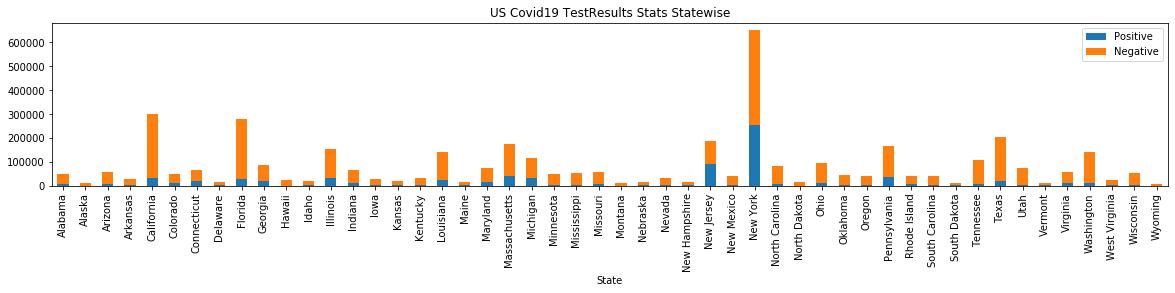

<Figure size 432x288 with 0 Axes>

In [8]:
# Use DataFrame.plot() in order to create a bar chart of the data
bar_chart_df.plot(kind="bar", figsize=(20,3), stacked=True,title = 'US Covid19 TestResults Stats Statewise')

# Display the chart
plt.show()
plt.tight_layout()

# Save the bar chart
plt.savefig('Statewise TestResults Stac Bar Chart')

In [9]:
# uploading cases/deaths by country and formatting dataframe
url2 = "https://coronavirus-19-api.herokuapp.com/countries"
response2 = requests.get(url2)
Countries_df = json_normalize(response2.json(), errors='ignore')
Countries_df = Countries_df.iloc[:,[0,1,2,3,4,5,6,7]] 

#imported data on SES and created a dataframe
globses = pd.read_csv("CSV Folder/GLOB.csv", encoding = 'latin-1')
globses = globses[globses["year"]==2010]
globses = globses.reset_index(drop = True)

#merged ses data with countries Covid Data
combined_Countries_df_data = pd.merge(Countries_df, globses, how="left", on=["country", "country"])  
combined_Countries_df_data.dropna(inplace =True) 
combined_Countries_df_data.reset_index(inplace = True, drop = True) 

#Clean up column header names
combined_Countries_df_data.rename(columns = {"country":"Country",
                           "cases":"Total Cases",
                           "todayCases":"Cases Today",
                           "deaths": "Deaths",
                           "todayDeaths":"Deaths Today",
                           "recovered":"Total Recovered",
                           "active":"Active Cases",
                           "critical": "Critical",
                           "gdppc": "GDP per Capita",
                           "yrseduc":"Avg Years Education"}, inplace = True)

#read in government type file and inner merge on country
gov_df = pd.read_csv("CSV Folder/Gov_type.csv")
combined_Countries_df_data2 = combined_Countries_df_data.merge(gov_df, how="inner", on="Country") 

In [10]:
combined_Countries_df_data2.head()

,Country,Total Cases,Cases Today,Deaths,Deaths Today,Total Recovered,Active Cases,Critical,unid,wbid,year,SES,GDP per Capita,Avg Years Education,popshare,Government Type
0,Spain,204178,3968,21282,430,82514.0,100382,7705,724.0,ESP,2010.0,85.359718,32506.434,10.3821,0.006912,parliamentary constitutional monarchy
1,Italy,183957,2729,24648,534,51600.0,107709,2471,380.0,ITA,2010.0,85.016357,36201.160,9.5096,0.008797,parliamentary republic
2,France,158050,2667,20796,531,39181.0,98073,5433,250.0,FRA,2010.0,88.194969,36872.227,10.5329,0.009650,semi-presidential republic
3,Germany,148291,1226,5033,171,95200.0,48058,2889,276.0,DEU,2010.0,92.546394,40428.723,11.8231,0.012136,federal parliamentary republic
4,Turkey,95591,4611,2259,119,14918.0,78414,1865,792.0,TUR,2010.0,60.248875,17076.605,7.0157,0.010731,presidential republic


In [11]:
locations = combined_Countries_df_data2['Country'].values.tolist()
cases = combined_Countries_df_data2['Active Cases'].astype(int)

# Plot Heatmap
fig = Map(center=(0, 0), zoom=2)

# Create Heatmap layer
heatmap = Heatmap(locations=locations, weights=cases, radius=20)

# Add Heatmap layer to map
fig.add_layer(heatmap)

# Display figure
fig.add_layer

<bound method Map.add_layer of Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text', 'zoom_out_title']), AttributionControl(options=['position', 'prefix'], position='bottomright')), default_style=MapStyle(), dragging_style=MapStyle(cursor='move'), layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_native_zoom', 'max_zoom', 'min_native_zoom', 'min_zoom', 'no_wrap', 'tile_size', 'tms']), Heatmap(gradient={0.4: 'blue', 0.6: 'cyan', 0.7: 'lime', 0.8: 'yellow', 1.0: 'red'}, locations=['Spain', 'Italy', 'France', 'Germany', 'Turkey', 'Iran', 'Brazil', 'Belgium', 'Canada', 'Switzerland', 'Portugal', 'India', 'Peru', 'Ireland', 'Sweden', 'Austria', 'Japan', 'Chile', 'Mexico', 'Denmark', 'Norway', 'Indonesia', 'Australia', 'Philippines', 'Malaysia', 'Dominican Republic', 'Panama', 'Finland', 'Egypt', 'South Africa', 'Morocco', 'Argentina', 'Algeria', 'Thailand', 'Greece', 'Hungary', 'Iraq'